In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
Image_size = 256
Batch_size = 32
Epochs = 30
Channels = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
len(dataset)

68

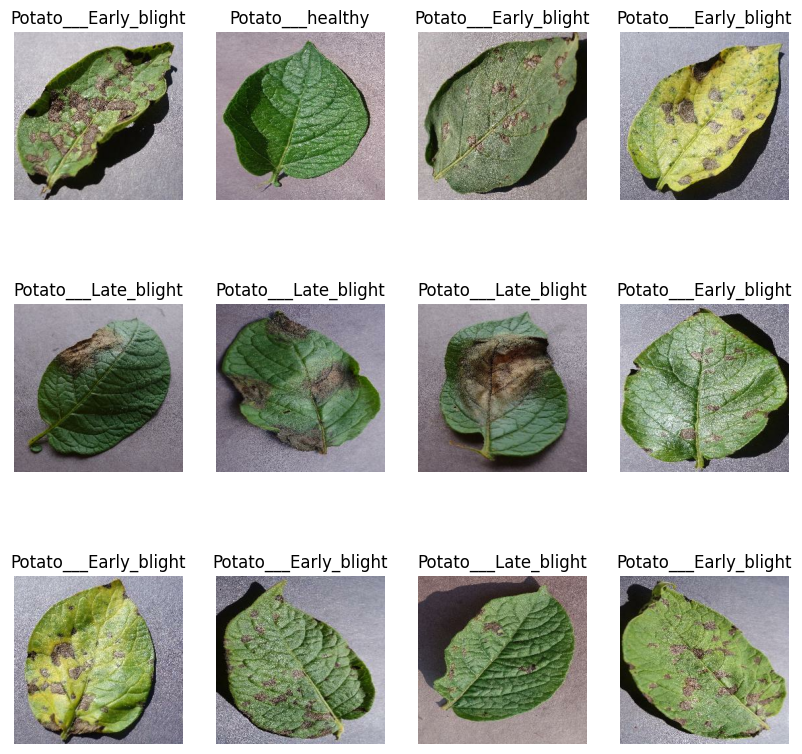

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        # print(image_batch[i].shape)

In [6]:
train_size = 0.8
68 * train_size



54.400000000000006

In [7]:
train_ds = dataset.take(54)
len(train_ds)

54

In [8]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [9]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [10]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    # Split datasets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, test_ds, val_ds


In [12]:
train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds), len(test_ds), len(val_ds))

54 8 6


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_size, Image_size),
    layers.Rescaling(1/255),
])

In [15]:
data_augmentation = Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2)
])

In [16]:
input_shape = (Batch_size, Image_size, Image_size, Channels)
n_classes = 3

model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),              
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds, batch_size=Batch_size, epochs=Epochs, verbose=1, validation_data=val_ds)

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')
plt.show

plt.subplot(1, 2, 1)
plt.plot(range(Epochs), loss, label='Training loss')
plt.plot(range(Epochs), val_loss, label='Validation loss')
plt.legend(loc='upper right right')
plt.title('training and validation loss')
plt.show()

In [ ]:
np.argmax([])

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print('actual label: ', class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(np.argmax(batch_prediction[0]))
    print(class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'actual: {actual_class}, \n predicted: {predicted_class}, \n confidence: {confidence}%')
        
        plt.axis('off')

In [ ]:
model_version = 1
model.save(f'../models/{model_version}')

In [ ]:
import os
model_version = max([int(i) for i in os.listdir('../models') + [0]]) + 1
model.save(f'../models/{m}')